In [1]:
import numpy as np
np.set_printoptions(precision=2)

from sklearn import datasets
import sklearn

import networkx as nx

from qiskit import BasicAer
from qiskit.optimization.ising import max_cut
from qiskit.optimization.ising.common import sample_most_likely
from qiskit.aqua.algorithms import VQE
import qiskit.aqua.components.optimizers as optimizers
import qiskit.aqua.components.variational_forms as variational_forms

import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline

## Clustering with Variation Quantum Eigensolver
### Max-Cut Problem Formulation

#### Load Iris dataset

In [2]:
n_datapoints = 10

data = datasets.load_iris()

X, y = data['data'][:,:2], data['target']
X, y = X[y != 2], y[y != 2]
X, y = sklearn.utils.shuffle(X, y)
X, y = X[:n_datapoints], y[:n_datapoints]

#### Calculate adjacency matrix

In [3]:
def computeAdjacencyMatrix(array): 
    adjacency_matrix = np.zeros((array.shape[0], array.shape[0]))
    
    for i in range(array.shape[0]):
        for j in range(array.shape[0]):
            adjacency_matrix[i, j] = np.linalg.norm(array[i] - array[j])
            
    return adjacency_matrix

W = computeAdjacencyMatrix(X)
W /= np.max(W)
print("(Weight) adjacency matrix:\n {}".format(W))

(Weight) adjacency matrix:
 [[0.   0.51 0.56 0.18 0.55 0.04 0.13 0.75 0.42 0.5 ]
 [0.51 0.   0.21 0.5  0.46 0.47 0.38 0.8  0.37 0.27]
 [0.56 0.21 0.   0.47 0.66 0.52 0.44 1.   0.56 0.48]
 [0.18 0.5  0.47 0.   0.67 0.17 0.19 0.91 0.54 0.57]
 [0.55 0.46 0.66 0.67 0.   0.52 0.48 0.34 0.14 0.19]
 [0.04 0.47 0.52 0.17 0.52 0.   0.09 0.74 0.39 0.46]
 [0.13 0.38 0.44 0.19 0.48 0.09 0.   0.73 0.34 0.39]
 [0.75 0.8  1.   0.91 0.34 0.74 0.73 0.   0.45 0.54]
 [0.42 0.37 0.56 0.54 0.14 0.39 0.34 0.45 0.   0.14]
 [0.5  0.27 0.48 0.57 0.19 0.46 0.39 0.54 0.14 0.  ]]


#### Constructing graph visualisation

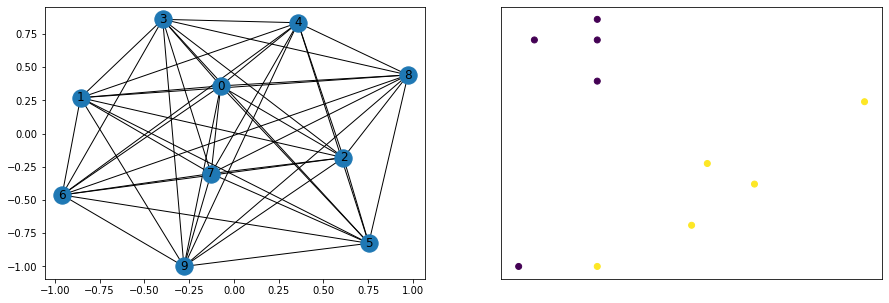

In [7]:
graph = nx.Graph()

graph.add_nodes_from(np.arange(0, n_datapoints))
edges=[(i, j, W[i,j]) for j in range(n_datapoints) for i in range(n_datapoints)]
graph.add_weighted_edges_from(edges)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, pos=pos, ax=axes[0])
axes[1].scatter(X[:,0], X[:,1], c=y)

#### Defining VQE

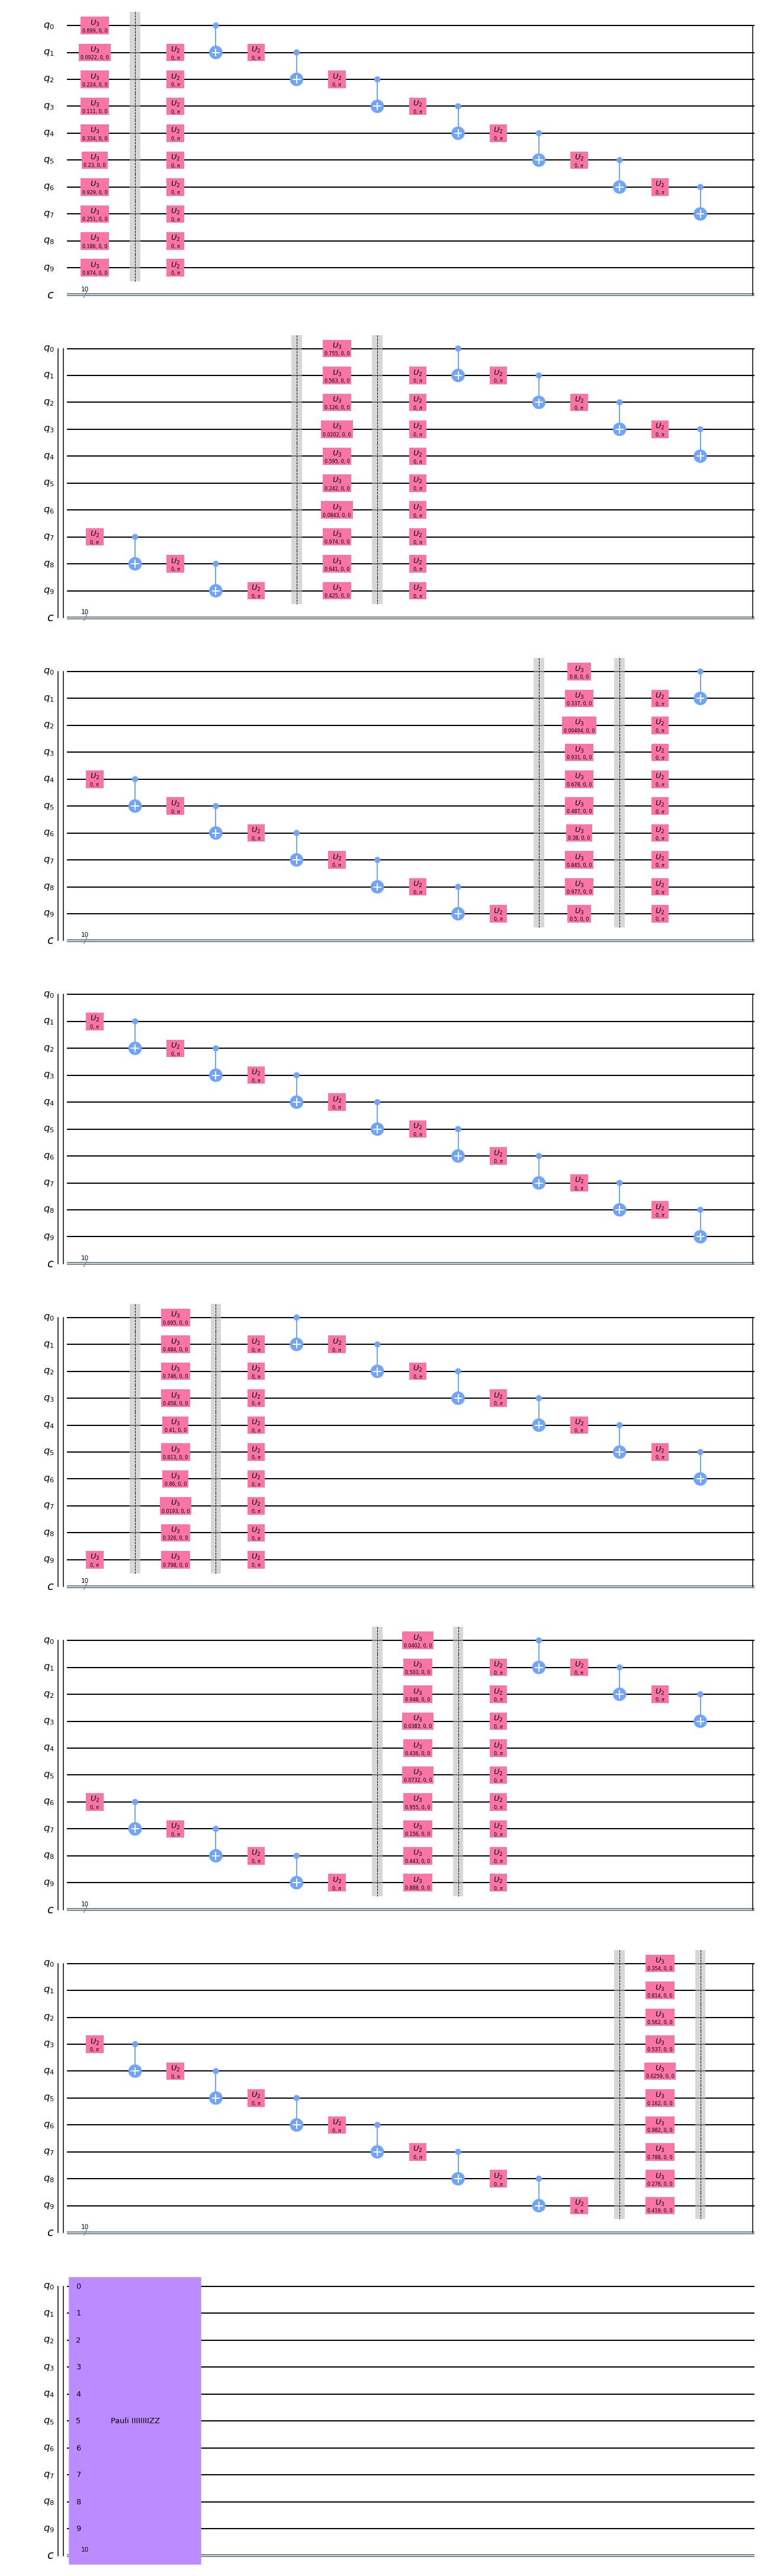

In [6]:
qubitOp, offset = max_cut.get_operator(W)

variantiona_form = variational_forms.RY(qubitOp.num_qubits,
                                        depth = 5,
                                        entanglement = 'linear')
vqe = VQE(qubitOp, 
          variantiona_form, 
          optimizers.SPSA(max_trials=100))

circuits = vqe.construct_circuit(np.random.random(variantiona_form.num_parameters))
circuits[0].draw()

#### Running the algorithm

In [8]:
backend = BasicAer.get_backend('statevector_simulator')
result = vqe.run(backend)

print("Eigenvector that corresponds to the minimal eigenvalue:\n   {}".format(
    result['eigvecs'][0]
))
binary_result = sample_most_likely(result['eigvecs'][0])
graph_solution = max_cut.get_graph_solution(binary_result)
print("Most likely binary string that correspond to the einenvector:\n   {}".format(
    graph_solution
))
print("Objective function value in solution:\n   {0:0.2f}".format(
    max_cut.max_cut_value(binary_result, W)
))

Eigenvector that corresponds to the minimal eigenvalue:
   [ 5.34e-04-2.41e-18j  9.21e-03-6.43e-17j -1.04e-03+6.88e-18j ...
 -4.87e-04+2.97e-18j -1.93e-04+1.08e-18j  5.74e-05-5.58e-19j]
Most likely binary string that correspond to the einenvector:
   [0. 1. 0. 0. 1. 0. 0. 1. 1. 1.]
Objective function value in solution:
   13.73


#### Results

In [12]:
print("Correctly assigned clusters:   {} / {}".format(np.sum(graph_solution == y), n_datapoints))

Correctly assigned clusters:   10 / 10


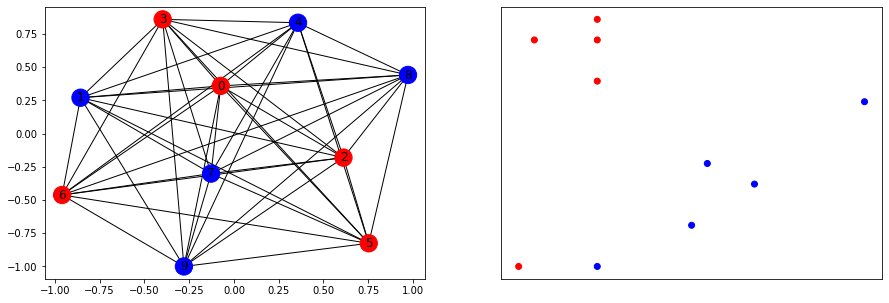

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
colors = ['r' if graph_solution[i] == 0 else 'b' for i in range(n_datapoints)]
nx.draw_networkx(graph, node_color=colors, pos=pos, ax=axes[0])
axes[1].scatter(X[:,0], X[:,1], c=colors)

### Literature:
1. https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/advanced/aqua/optimization/max_cut_and_tsp.ipynb
2. https://qiskit.org/textbook/ch-applications/vqe-molecules.html#implementation